In [54]:
import librosa.display
import os
from scipy.io import wavfile
import librosa
import os
import pandas as pd
import numpy as np
import re
import glob
import matplotlib.pyplot as plt

## Silence elimination

In [13]:
def eliminar_silencio(ruta_base: str, carpetas: list) -> None:
    """
    Removes the silence from the .wav files in the specified folders and saves the clean files in a new folder called 'clean_audios'.

    :param ruta_base: The base path where the folders with the audio files are located.
    :type ruta_base: str
    :param carpetas: A list with the names of the folders to be processed.
    :type carpetas: list
    :return: None
    """

    if not os.path.exists("../data/clean_audios"):
        os.mkdir("../data/clean_audios")

    for carpeta in carpetas:
        archivos_wav = glob.glob(os.path.join(ruta_base, carpeta, '**', '*.wav'), recursive=True)
        for archivo in archivos_wav:
            audio, tasa_muestreo = librosa.load(archivo, sr=None)
            audio_sin_silencio, indices_no_silencio = librosa.effects.trim(audio)
            ruta_limpia = os.path.join("../data/clean_audios", carpeta, os.path.relpath(archivo, os.path.join(ruta_base, carpeta)))
            os.makedirs(os.path.dirname(ruta_limpia), exist_ok=True)
            wavfile.write(ruta_limpia, tasa_muestreo, audio_sin_silencio)


In [14]:
eliminar_silencio("../data/audios/",[ "iemocap"])

## Dataframe Creation

### Ravdess

In [55]:
ravdess = '../data/clean_audios/ravdess'

In [56]:
def create_rav_emotion_df(ruta_clean_audios: str) -> pd.DataFrame:
    """
    Creates a dataframe with two columns: emotion and path, using the emotion label encoded in the file names
    of the .wav files in the specified directory.

    :param ruta_clean_audios: The path where the clean audio files are located.
    :type ruta_clean_audios: str
    :return: A pandas dataframe with the emotion label and the path of each file.
    :rtype: pd.DataFrame
    """

    # List to store the emotion and path for each file
    emotion_paths = []

    # Loop through all the .wav files in the specified directory
    for root, _, files in os.walk(ruta_clean_audios):
        for file in files:
            if file.endswith(".wav"):
                # Get the emotion label from the file name
                emotion_label = int(file[7])

                # Assign emotion based on label
                if emotion_label == 1 or emotion_label == 2:
                    emotion = "neutral"
                elif emotion_label == 3:
                    emotion = "joy"
                elif emotion_label == 4:
                    emotion = "sadness"
                elif emotion_label == 5 or emotion_label == 7:
                    emotion = "anger"
                elif emotion_label == 6:
                    emotion = "fear"
                elif emotion_label == 8:
                    emotion = "surprise"

                # Create tuple with emotion and path
                path = os.path.join(root, file)
                emotion_path = (emotion, path)

                # Append to list
                emotion_paths.append(emotion_path)

    # Create pandas dataframe with emotion and path columns
    df = pd.DataFrame(emotion_paths, columns=["emotion", "path"])

    return df


In [57]:
ravdess_df=create_rav_emotion_df(ravdess)
ravdess_df.head(5)

,emotion,path
0,neutral,../data/clean_audios/ravdess\03-01-01-01-01-01...
1,neutral,../data/clean_audios/ravdess\03-01-01-01-01-01...
2,neutral,../data/clean_audios/ravdess\03-01-01-01-01-01...
3,neutral,../data/clean_audios/ravdess\03-01-01-01-01-01...
4,neutral,../data/clean_audios/ravdess\03-01-01-01-01-01...


### Iemocap

In [58]:
iemocapCsv = '../data/aud_em/iemo.csv'

In [59]:
def create_path_dataframe(ruta_csv):
    """
    Reads a csv file with a 'path' column that contains file paths in a specific format,
    modifies the paths to include the correct folder and replaces the emotion values with
    the desired values, then filters out any rows with emotion values that are not in the list
    of emotions to consider.

    :param ruta_csv: The path of the csv file to read.
    :type ruta_csv: str
    :return: A pandas dataframe with the modified paths.
    :rtype: pandas.DataFrame
    """

    # List of emotions to consider
    emotions_to_consider = ['neutral', 'joy', 'sadness', 'anger', 'fear', 'surprise']

    # Read the csv file
    df = pd.read_csv(ruta_csv)

    # Modify the 'path' column
    df['path'] = df['path'].apply(lambda x: "../data/clean_audios/iemocap/" + x)

    # Replace the 'emotion' values
    df['emotion'] = df['emotion'].replace({'neu': 'neutral', 'fru': 'anger', 'sad': 'sadness', 'sur': 'surprise',
                                           'ang': 'anger', 'hap': 'joy', 'exc': 'joy', 'fea': 'fear', 'dis': 'anger'})

    # Filter out any rows with emotion values that are not in the list of emotions to consider
    df = df[df['emotion'].isin(emotions_to_consider)]

    # Select only the 'path' column and return the resulting dataframe
    return df[['emotion', 'path']]


In [60]:
iemocap_df = create_path_dataframe(iemocapCsv)
iemocap_df.head(5)

,emotion,path
0,neutral,../data/clean_audios/iemocap/Session1/sentence...
1,anger,../data/clean_audios/iemocap/Session1/sentence...
3,surprise,../data/clean_audios/iemocap/Session1/sentence...
4,neutral,../data/clean_audios/iemocap/Session1/sentence...
6,anger,../data/clean_audios/iemocap/Session1/sentence...


### TESS

In [61]:
tess = '../data/clean_audios/TESS'

In [62]:
def create_emotion_path_dataframe(ruta: str) -> pd.DataFrame:
    """
    Creates a dataframe with two columns: 'emotion' and 'path'. The function reads the names of the .wav files
    contained in the directory specified by the path parameter and, based on the presence of certain keywords
    within the file name, assigns an emotion value to the 'emotion' column. The 'path' column contains the full path
    to the .wav file. Only emotions that are explicitly defined are included in the dataframe.

    :param ruta: The path where the .wav files are located.
    :type ruta: str
    :return: A pandas dataframe with two columns: 'emotion' and 'path'.
    :rtype: pandas.DataFrame
    """
    emotions = {'fear': 'fear', 'ps': 'surprise', 'sad': 'sadness', 'angry': 'anger', 'disgust': 'anger', 'happy': 'joy', 'neutral': 'neutral'}
    file_paths = [os.path.join(ruta, f) for f in os.listdir(ruta) if f.endswith('.wav')]
    data = {'emotion': [], 'path': []}
    for path in file_paths:
        emotion = None
        for word, value in emotions.items():
            if word in path.lower():
                emotion = value
                break
        if emotion is not None:
            data['emotion'].append(emotion)
            data['path'].append(path)
    df = pd.DataFrame(data)
    return df

In [63]:
tess_df=create_emotion_path_dataframe(tess)
tess_df.head(5)

,emotion,path
0,anger,../data/clean_audios/TESS\OAF_back_angry.wav
1,anger,../data/clean_audios/TESS\OAF_back_disgust.wav
2,fear,../data/clean_audios/TESS\OAF_back_fear.wav
3,joy,../data/clean_audios/TESS\OAF_back_happy.wav
4,neutral,../data/clean_audios/TESS\OAF_back_neutral.wav


## Dataframe Fusion

In [64]:
merged_df = pd.concat([tess_df, iemocap_df, ravdess_df], ignore_index=True)
merged_df.head(5)

,emotion,path
0,anger,../data/clean_audios/TESS\OAF_back_angry.wav
1,anger,../data/clean_audios/TESS\OAF_back_disgust.wav
2,fear,../data/clean_audios/TESS\OAF_back_fear.wav
3,joy,../data/clean_audios/TESS\OAF_back_happy.wav
4,neutral,../data/clean_audios/TESS\OAF_back_neutral.wav


## Audio Length

In [115]:
def obtener_duraciones_df(df, column_path: str) -> list:
    """
    Receives a pandas dataframe with a 'path' column and returns a list of
    the durations of every audio file in the path column.

    :param df: The pandas dataframe with the 'path' column.
    :type df: pandas.DataFrame
    :param column_path: The name of the column that contains the audio file paths.
    :type column_path: str
    :return: A list of durations.
    :rtype: list
    """
    duraciones = []
    for path in df[column_path]:
        if ".wav" in path:
            duracion = librosa.get_duration(filename=path)
            duraciones.append(duracion)
    return duraciones


In [116]:
duraciones = obtener_duraciones_df(merged_df, 'path')
print("Number of audio files found:", len(duraciones))

C:\Users\juand\AppData\Local\Temp\ipykernel_3460\75477826.py:16: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duracion = librosa.get_duration(filename=path)


Number of audio files found: 11769


In [122]:
print(type(duraciones))

<class 'list'>


In [148]:
recommended_n_fft = 2 ** (len(bin(2)) - 2)
print(recommended_n_fft)

4


In [145]:
recommended_n_ftt = calcular_longitud_promedio(merged_df)
print(recommended_n_ftt)

KeyboardInterrupt: 


## Distribution and segment duration determination

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def graficar_distribucion(duraciones:list) -> float:
    """
    Receives a list of durations and plots their distribution using a Seaborn kernel density plot.
    Also, calculates the value of the duration of the segments.
    
    :param duraciones: The list of durations to plot.
    :type duraciones: list
    :return: The minimum duration for the creation of the segments
    :rtype: list
    """
    audios_sorted = sorted(duraciones)
    duracion_max = audios_sorted[-1]
    pct_per_duracion = []
    for i in range(int(duracion_max)+1):
        pct_per_duracion.append(sum(d >= i for d in audios_sorted) / len(audios_sorted) * 100)
        
    plt.plot(np.arange(duracion_max), pct_per_duracion)
    minima= np.percentile(audios_sorted, 5)
    plt.xlabel('Duración (segundos)')
    plt.ylabel('Porcentaje de audios')
    plt.title('Distribución de duraciones')
    plt.axhline(y=95, color='r', linestyle='--')
    plt.axvline(x=minima, color='g', linestyle='--')
    print('95% of the wav files surpases ',minima,' seconds')
    return plt.gcf(), minima


<IPython.core.display.Javascript object>


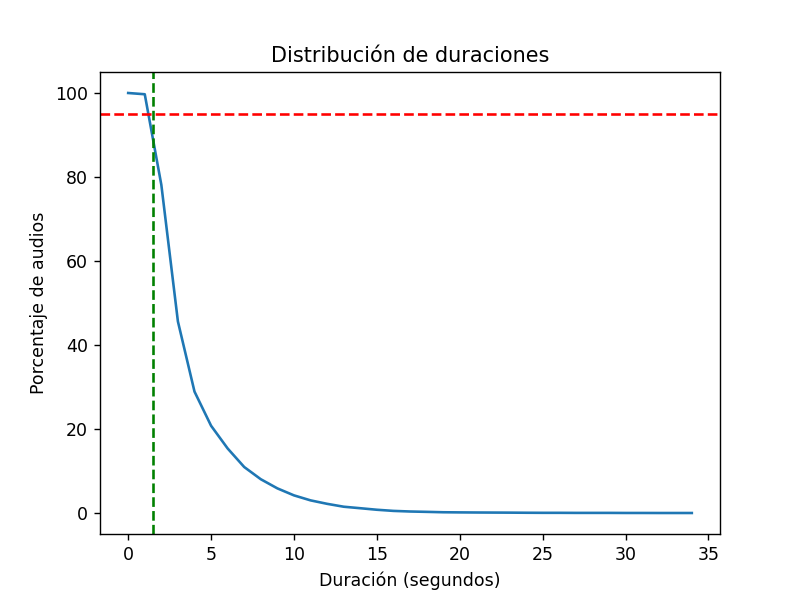

95% of the wav files surpases  1.4877529286474973  seconds


In [134]:
%matplotlib notebook
fig, minima = graficar_distribucion(duraciones)
fig.show()

## Features extraction

In [161]:
sr = 22050
hop_length = round((1.48/2) * 1000)
hop_length = int(hop_length/10) * 10
n_mfcc = 13

In [159]:
def find_optimal_n_fft(df: pd.DataFrame, duration: float, sr: int, hop_length: int) -> int:
    n_fft_values = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    num_frames = []
    for n_fft in n_fft_values:
        frames = 0
        for path in df['path']:
            if ".wav" in path:
                # Carga el archivo de audio
                audio, sr = librosa.load(path, sr=sr)

                # Calcula la longitud de la ventana en muestras
                longitud_ventana = int(duration * sr)

                if len(audio) >= longitud_ventana:
                    # Calcula el centro del audio
                    centro_audio = len(audio) // 2

                    # Retrocede y avanza la mitad de la longitud de la ventana
                    inicio_ventana = centro_audio - (longitud_ventana // 2)
                    fin_ventana = centro_audio + (longitud_ventana // 2)

                    # Extrae los datos dentro de la ventana
                    datos_ventana = audio[inicio_ventana:fin_ventana]

                    # Calcula los frames utilizando librosa.util.frame
                    frames += librosa.util.frame(datos_ventana, frame_length=n_fft, hop_length=hop_length).shape[1]

        num_frames.append(frames)

    # Selecciona el valor de n_fft que genere la mayor cantidad de frames
    optimal_n_fft = n_fft_values[num_frames.index(max(num_frames))]

    return optimal_n_fft


In [160]:
optimal_n_fft = find_optimal_n_fft(merged_df, minima, sr, hop_length)
print(optimal_n_fft)

16


In [170]:
import numpy as np

def extract_features_from_wav_files(df: pd.DataFrame, duration: float, sr, optimal_n_fft, n_mfcc, hop_length) -> pd.DataFrame:
    """
    Extracts features from WAV files in a given DataFrame, including MFCCs and DFTs.
        df (pd.DataFrame): DataFrame with paths to WAV files and corresponding emotion labels.
        duration (float): Duration of the window in seconds.
        sr (int): Sampling rate.
        optimal_n_fft (int): Optimal FFT window length.
        n_mfcc (int): Number of MFCC coefficients to extract.
        hop_length (int): Number of samples to advance between successive frames.

    Returns:
        pd.DataFrame: DataFrame with extracted features (MFCCs and DFTs) and corresponding emotion labels.
    """
    features = []
    for path in df['path']:
        if ".wav" in path:
            # Carga el archivo de audio
            audio, sr = librosa.load(path, sr=sr)

            # Calcula el centro del audio
            centro_audio = len(audio) // 2

            # Calcula la longitud de la ventana en muestras
            longitud_ventana = int(duration * sr)

            # Retrocede y avanza la mitad de la longitud de la ventana
            inicio_ventana = centro_audio - (longitud_ventana // 2)
            fin_ventana = centro_audio + (longitud_ventana // 2)

            # Extrae los datos dentro de la ventana
            datos_ventana = audio[inicio_ventana:fin_ventana]

            # Calcula la Transformada Discreta de Fourier
            dft = np.abs(np.fft.fft(datos_ventana, n=optimal_n_fft))

            # Extrae los coeficientes MFCC de la ventana
            mfcc = librosa.feature.mfcc(y=datos_ventana, sr=sr, n_mfcc=n_mfcc, n_fft=optimal_n_fft, hop_length=hop_length)

            # Calcula la media de cada coeficiente MFCC
            mfcc_mean = mfcc.mean(axis=1)

            # Agrega los coeficientes MFCC y la DFT a la lista de características
            features.append(np.concatenate((mfcc_mean, dft)))

    # Crea un dataframe con las características extraídas y la columna de emociones
    feature_names = [f'mfcc{i}' for i in range(1, n_mfcc+1)] + [f'dft{i}' for i in range(optimal_n_fft)]
    features_df = pd.DataFrame(features, columns=feature_names)
    features_df['emotion'] = df['emotion'].tolist()

    return features_df


In [172]:
mfcc_emo_df=extract_features_from_wav_files(merged_df, minima, sr,optimal_n_fft,n_mfcc,hop_length)
mfcc_emo_df.to_csv("../data/aud_em/mfcc_emo_df.csv", index=False)


C:\Users\juand\AppData\Roaming\Python\Python39\site-packages\librosa\feature\spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
C:\Users\juand\AppData\Roaming\Python\Python39\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=16 is too large for input signal of length=5
  warnings.warn(
C:\Users\juand\AppData\Roaming\Python\Python39\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=16 is too large for input signal of length=11
  warnings.warn(
C:\Users\juand\AppData\Roaming\Python\Python39\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=16 is too large for input signal of length=2
  warnings.warn(


In [173]:
mfcc_emo_df= pd.read_csv("../data/aud_em/mfcc_emo_df.csv")
mfcc_emo_df.head()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,dft7,dft8,dft9,dft10,dft11,dft12,dft13,dft14,dft15,emotion
0,-1046.097534,-15.038372,-9.006992,-3.499521,0.029980,9.634868,5.672071,-2.018028,-16.885035,-1.916777,...,0.000342,0.000348,0.000342,0.000286,0.000225,0.000334,0.000624,0.000605,0.001076,anger
1,-1108.186646,-8.099326,-11.132999,-4.965306,2.276421,7.958720,7.126535,-3.339881,-16.540642,-1.019568,...,0.012129,0.013316,0.012129,0.011815,0.014943,0.017587,0.019817,0.034838,0.019604,anger
2,-1099.581421,-17.339388,-7.187382,-5.643442,1.623265,8.916953,6.333152,-2.029551,-18.112698,-0.636720,...,0.010482,0.004866,0.010482,0.015158,0.010975,0.019587,0.003695,0.003055,0.004699,fear
3,-1105.150757,-11.412861,-9.707479,-4.983124,1.509630,8.991771,6.266232,-2.720575,-16.731367,-1.593392,...,0.019370,0.018813,0.019370,0.018107,0.023871,0.020788,0.039592,0.069957,0.128835,joy
4,-1109.215576,-7.140424,-11.328695,-5.066000,2.499227,7.641959,7.434227,-3.767665,-16.098589,-1.024969,...,0.003903,0.008225,0.003903,0.005681,0.007426,0.018349,0.037029,0.002399,0.010037,neutral
